In [ ]:
## ML MODEL

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91738\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [ ]:
type(ss_1)

dict

<h1> Decision Tree </h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder

from scipy.sparse import hstack

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from prettytable import PrettyTable



## 1.1 Loading Data

In [ ]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
import pandas as pd
data = pd.read_csv('preprocessed_data.csv')

In [ ]:
data = pd.read_csv('preprocessed_data.csv', nrows=50000)
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)



<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,stratify=y)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train, test_size= 0.33, stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding essay </h2>

### 1.3.1 TF-IDF vectorization on eassy

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train["essay"].values)

X_train_tfidf_essay = vectorizer.transform(X_train["essay"].values)
X_cv_tfidf_essay = vectorizer.transform(X_cv["essay"].values)
X_test_tfidf_essay = vectorizer.transform(X_test["essay"].values)

print(X_train_tfidf_essay.shape)
print(X_cv_tfidf_essay.shape)
print(X_test_tfidf_essay.shape)

essay_ = vectorizer.get_feature_names()


(22445, 5000)
(11055, 5000)
(16500, 5000)


### 1.3.2 tf idf w2v vectorization on essay 

In [ ]:
#please use below code to load glove vectors 
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
from tqdm import tqdm
def tfidf_w2v(sent):
    avg_w2v_vectors = [] 
    for sentence in tqdm(sent): 
        vector = np.zeros(300) 
        cnt_words =0
        for word in sentence.split(): 
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
        vec = avg_w2v_vectors

    return vec

    


In [ ]:
X_train_essay_tfidfw2v = tfidf_w2v(X_train['essay'])
X_cv_essay_tfidfw2v = tfidf_w2v(X_cv['essay'])
X_test_essay_tfidfw2v = tfidf_w2v(X_test['essay'])


100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:04<00:00, 3667.18it/s]


In [ ]:
X_train_essay_tfidfw2v = np.array(X_train_essay_tfidfw2v)
X_cv_essay_tfidfw2v = np.array(X_cv_essay_tfidfw2v)
X_test_essay_tfidfw2v = np.array(X_test_essay_tfidfw2v)


### 1.3.3 sentiment scores of essays

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

In [ ]:
def sent_score(senti):
    nega = []
    neut = []
    posi = []
    comp = []
    for essay in tqdm(senti):

        ss = sid.polarity_scores(essay)
        nega.append(ss['neg'])
        neut.append(ss['neu'])
        posi.append(ss['pos'])
        comp.append(ss['compound'])

    return np.array([nega,neut,posi,comp])

In [ ]:
X_train_senti=sent_score(X_train['essay'].values)
X_cv_senti=sent_score(X_cv['essay'].values)
X_test_senti=sent_score(X_test['essay'].values)

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [00:29<00:00, 563.24it/s]


In [ ]:
X_train_senti[0].reshape(22445,1).shape

(22445, 1)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

## 1.4.1 encoding numerical features

### 1.4.1.1 price

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))




### 1.4.1.2 teacher_number_of_previously_posted_projects	

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_previously_posted_projects_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_previously_posted_projects_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_previously_posted_projects_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



## 1.4.2 encoding categorical features

### 1.4.2.1 teacher_prefix

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train['teacher_prefix'].values.reshape(-1,1))

X_train_teacher_prefix_ohe = ohe.transform(X_train['teacher_prefix'].values.reshape(-1,1))
X_cv_teacher_prefix_ohe = ohe.transform(X_cv['teacher_prefix'].values.reshape(-1,1))
X_test_teacher_prefix_ohe = ohe.transform(X_test['teacher_prefix'].values.reshape(-1,1))

teacher_prefix_ = ohe.get_feature_names()

### 1.4.2.2 project_grade_category

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train['project_grade_category'].values.reshape(-1,1))

X_train_project_grade_category_ohe = ohe.transform(X_train['project_grade_category'].values.reshape(-1,1))
X_cv_project_grade_category_ohe = ohe.transform(X_cv['project_grade_category'].values.reshape(-1,1))
X_test_project_grade_category_ohe = ohe.transform(X_test['project_grade_category'].values.reshape(-1,1))

project_grade_category_ = ohe.get_feature_names()


### 1.4.2.3 school_state

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train['school_state'].values.reshape(-1,1))

X_train_school_state_ohe = ohe.transform(X_train['school_state'].values.reshape(-1,1))
X_cv_school_state_ohe = ohe.transform(X_cv['school_state'].values.reshape(-1,1))

X_test_school_state_ohe = ohe.transform(X_test['school_state'].values.reshape(-1,1))


school_state_ = ohe.get_feature_names()


### 1.4.2.4 clean_categories

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train['clean_categories'].values.reshape(-1,1))

X_train_clean_categories_ohe = ohe.transform(X_train['clean_categories'].values.reshape(-1,1))
X_cv_clean_categories_ohe = ohe.transform(X_cv['clean_categories'].values.reshape(-1,1))
X_test_clean_categories_ohe = ohe.transform(X_test['clean_categories'].values.reshape(-1,1))

clean_categories_ = ohe.get_feature_names()


### 1.4.2.5 clean_subcategories

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train['clean_subcategories'].values.reshape(-1,1))

X_train_clean_subcategories_ohe = ohe.transform(X_train['clean_subcategories'].values.reshape(-1,1))
X_cv_clean_subcategories_ohe = ohe.transform(X_cv['clean_subcategories'].values.reshape(-1,1))
X_test_clean_subcategories_ohe = ohe.transform(X_test['clean_subcategories'].values.reshape(-1,1))

clean_subcategories_ = ohe.get_feature_names()


In [ ]:
X_train_clean_subcategories_ohe.shape

(22445, 330)

## set -1

In [ ]:
from scipy.sparse import hstack

X_tr_set1=hstack((X_train_teacher_prefix_ohe,X_train_project_grade_category_ohe,X_train_school_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_price_norm,X_train_previously_posted_projects_norm,X_train_tfidf_essay,X_train_senti[0].reshape(22445,1),X_train_senti[1].reshape(22445,1),X_train_senti[2].reshape(22445,1),X_train_senti[3].reshape(22445,1)))

X_cv_set1=hstack((X_cv_teacher_prefix_ohe,X_cv_project_grade_category_ohe,X_cv_school_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_price_norm,X_cv_previously_posted_projects_norm,X_cv_tfidf_essay,X_cv_senti[0].reshape(11055,1),X_cv_senti[1].reshape(11055,1),X_cv_senti[2].reshape(11055,1),X_cv_senti[3].reshape(11055,1)))

X_te_set1=hstack((X_test_teacher_prefix_ohe,X_test_project_grade_category_ohe,X_test_school_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_price_norm,X_test_previously_posted_projects_norm,X_test_tfidf_essay,X_test_senti[0].reshape(16500,1),X_test_senti[1].reshape(16500,1),X_test_senti[2].reshape(16500,1),X_test_senti[3].reshape(16500,1)))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt=DecisionTreeClassifier()
params = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}

clf = GridSearchCV(dt,params,cv=3,n_jobs=-1,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_set1,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

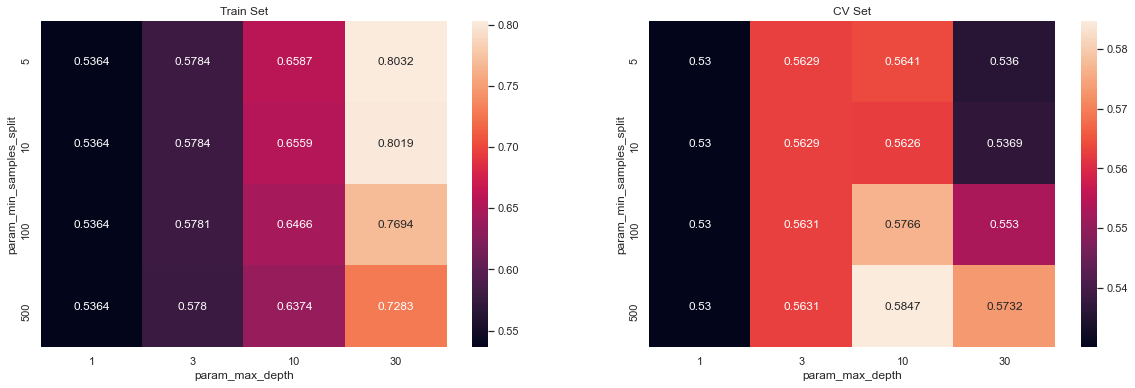

In [ ]:
import seaborn as sns; sns.set()
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 500}

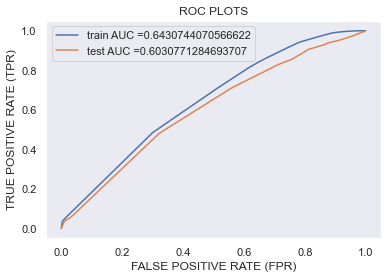

In [ ]:
dt=DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500)
dt.fit(X_tr_set1, y_train);

y_train_pred = clf.predict_proba(X_tr_set1)[:,1]  
y_test_pred = clf.predict_proba(X_te_set1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE (FPR)")
plt.ylabel("TRUE POSITIVE RATE (TPR)")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

In [ ]:
#function to get heatmap confusion matrix
def get_confusion_matrix(clf,X_te,y_test):
    y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

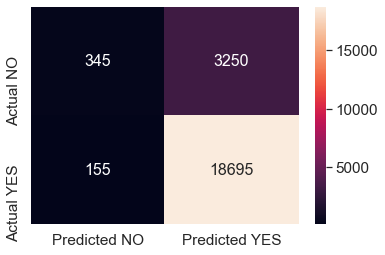

In [ ]:
#confusion matrix - train data
get_confusion_matrix(clf,X_tr_set1,y_train)

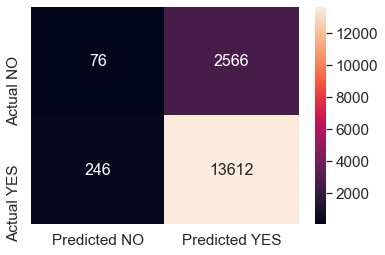

In [ ]:
#connfusion matrix - test data
get_confusion_matrix(clf,X_te_set1,y_test)

In [ ]:
def collect_prediction(prob, threshould, fpr, tpr):
    predictions = []
    t = threshould[np.argmax(fpr*(1-tpr))]
    for i in prob:
        if(i>=t):
            predictions.append(1)
        else:
            predictions.append(0)  
    return predictions

In [ ]:
def collect_fpr(y_test, predictions):
    fpr = []
    for i in range(len(y_test)):
        if(y_test[i] == 0 and predictions[i]==1):
            fpr.append(i)
    return fpr

In [ ]:
predictions = collect_prediction(y_test_pred, te_thresholds, test_fpr, test_tpr)


fpr = collect_fpr(y_test, predictions)

essay = X_test['essay'].to_frame()
essay = essay.reset_index()

price = X_test['price'].to_frame()
price = price.reset_index()

teacher_number_of_previously_posted_projects = X_test['teacher_number_of_previously_posted_projects'].to_frame()
teacher_number_of_previously_posted_projects = teacher_number_of_previously_posted_projects.reset_index()

false_essay = []
false_price = []
false_teacher_number_of_previously_posted_projects = []
for i in fpr:
    false_essay.append(essay.values[i][1:][0])
    false_price.append(price.values[i][1:][0])
    false_teacher_number_of_previously_posted_projects.append(teacher_number_of_previously_posted_projects.values[i][1:][0])
        
#print(len(false_essay), len(false_price), len(false_teacher_number_of_previously_posted_projects))

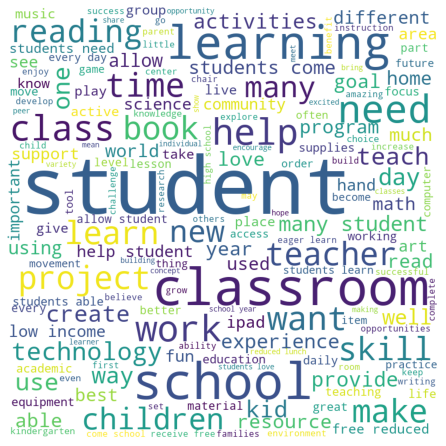

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_essay:
    val = str(val)
    val = val.lower()
    tokens = val.split()
    for words in tokens:
        if(words == 'nan' or words == 'nannan'):
            continue
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

observation:
- most common words are student,school,learning,classroom.

C:\Users\91738\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


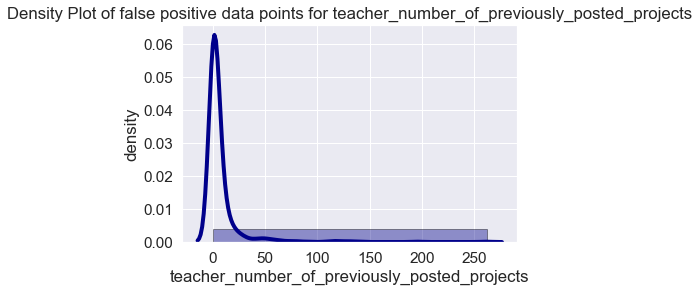

In [ ]:
sns.distplot(false_teacher_number_of_previously_posted_projects, hist=True, kde=True, 
             bins=1, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot of false positive data points for teacher_number_of_previously_posted_projects') 
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('density')
plt.show()

observations:
- no.of projects perviously posted by teachers are mostly in the range of 1-25

## set -2

In [ ]:
from scipy.sparse import hstack

X_tr_set2=hstack((X_train_teacher_prefix_ohe,X_train_project_grade_category_ohe,X_train_school_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_price_norm,X_train_previously_posted_projects_norm,X_train_essay_tfidfw2v,X_train_senti[0].reshape(22445,1),X_train_senti[1].reshape(22445,1),X_train_senti[2].reshape(22445,1),X_train_senti[3].reshape(22445,1)))

X_cv_set2=hstack((X_cv_teacher_prefix_ohe,X_cv_project_grade_category_ohe,X_cv_school_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_price_norm,X_cv_previously_posted_projects_norm,X_cv_essay_tfidfw2v,X_cv_senti[0].reshape(11055,1),X_cv_senti[1].reshape(11055,1),X_cv_senti[2].reshape(11055,1),X_cv_senti[3].reshape(11055,1)))

X_te_set2=hstack((X_test_teacher_prefix_ohe,X_test_project_grade_category_ohe,X_test_school_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_price_norm,X_test_previously_posted_projects_norm,X_test_essay_tfidfw2v,X_test_senti[0].reshape(16500,1),X_test_senti[1].reshape(16500,1),X_test_senti[2].reshape(16500,1),X_test_senti[3].reshape(16500,1)))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt=DecisionTreeClassifier()
params = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}

clf = GridSearchCV(dt,params,cv=3,n_jobs=-1,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_set2,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

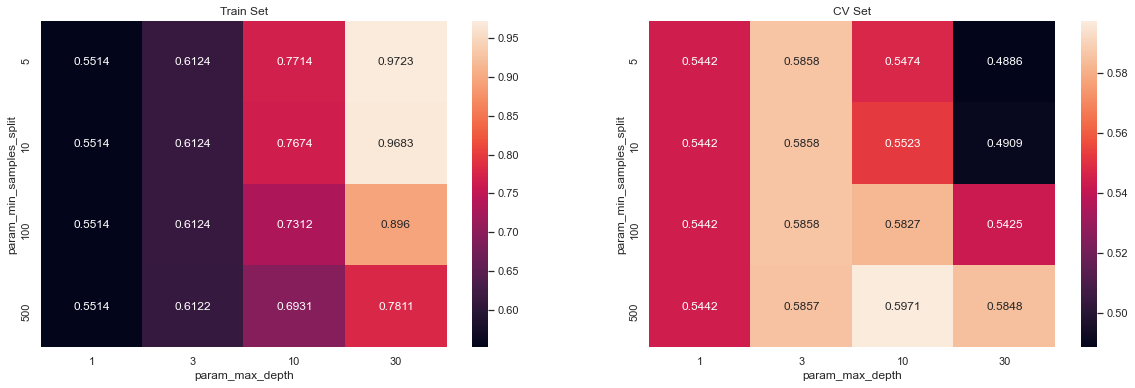

In [ ]:
import seaborn as sns; sns.set()
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 500}

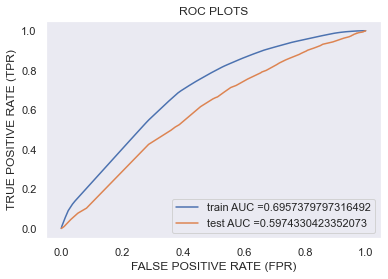

In [ ]:
dt=DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500)
dt.fit(X_tr_set2, y_train);

y_train_pred = clf.predict_proba(X_tr_set2)[:,1]  
y_test_pred = clf.predict_proba(X_te_set2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE (FPR)")
plt.ylabel("TRUE POSITIVE RATE (TPR)")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

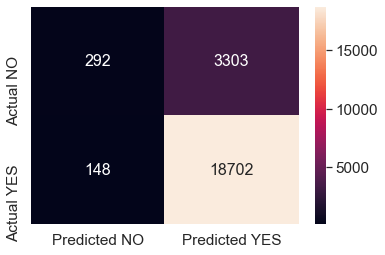

In [ ]:
#confusion matrix - train data
get_confusion_matrix(clf,X_tr_set2,y_train)

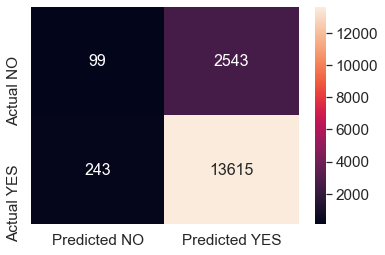

In [ ]:
#connfusion matrix - test data
get_confusion_matrix(clf,X_te_set2,y_test)

In [ ]:
predictions = collect_prediction(y_test_pred, te_thresholds, test_fpr, test_tpr)


fpr = collect_fpr(y_test, predictions)

essay = X_test['essay'].to_frame()
essay = essay.reset_index()

price = X_test['price'].to_frame()
price = price.reset_index()

teacher_number_of_previously_posted_projects = X_test['teacher_number_of_previously_posted_projects'].to_frame()
teacher_number_of_previously_posted_projects = teacher_number_of_previously_posted_projects.reset_index()

false_essay = []
false_price = []
false_teacher_number_of_previously_posted_projects = []
for i in fpr:
    false_essay.append(essay.values[i][1:][0])
    false_price.append(price.values[i][1:][0])
    false_teacher_number_of_previously_posted_projects.append(teacher_number_of_previously_posted_projects.values[i][1:][0])
        
print(len(false_essay), len(false_price), len(false_teacher_number_of_previously_posted_projects))

1024 1024 1024


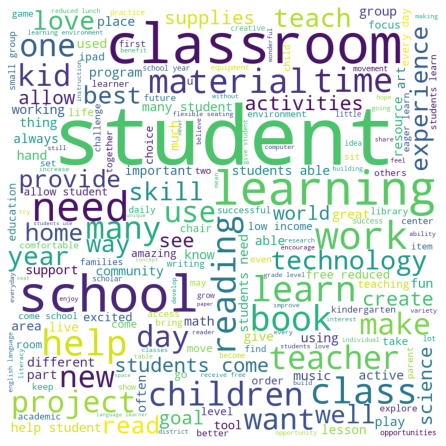

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_essay:
    val = str(val)
    val = val.lower()
    tokens = val.split()
    for words in tokens:
        if(words == 'nan' or words == 'nannan'):
            continue
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

observation:
- most common words are student,school,learning,classroom.

C:\Users\91738\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


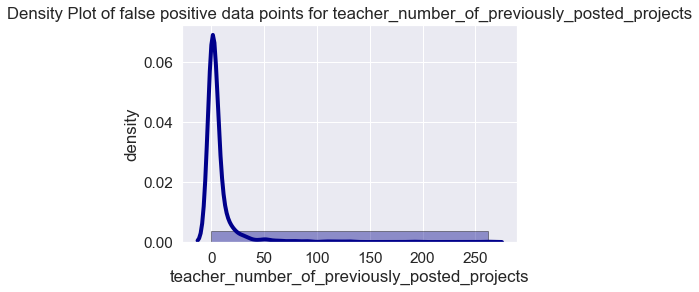

In [ ]:
sns.distplot(false_teacher_number_of_previously_posted_projects, hist=True, kde=True, 
             bins=1, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot of false positive data points for teacher_number_of_previously_posted_projects') 
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('density')
plt.show()

observations:
- no.of projects perviously posted by teachers are mostly in the range of 1-25

In [ ]:
dt=DecisionTreeClassifier(class_weight='balanced', min_samples_split=500)
dt.fit(X_tr_set1, y_train)
dt.feature_importances_

array([0.        , 0.        , 0.        , ..., 0.01192579, 0.00166456,
       0.00308578])

In [ ]:
X_t = X_tr_set1.todense()[:, dt.feature_importances_ != 0]
X_c = X_cv_set1.todense()[:, dt.feature_importances_ != 0]
X_tt = X_te_set1.todense()[:, dt.feature_importances_ != 0]

In [ ]:
dt=DecisionTreeClassifier()
params = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}

clf = GridSearchCV(dt,params,cv=3,n_jobs=-1,scoring='roc_auc',return_train_score=True)
clf.fit(X_t,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

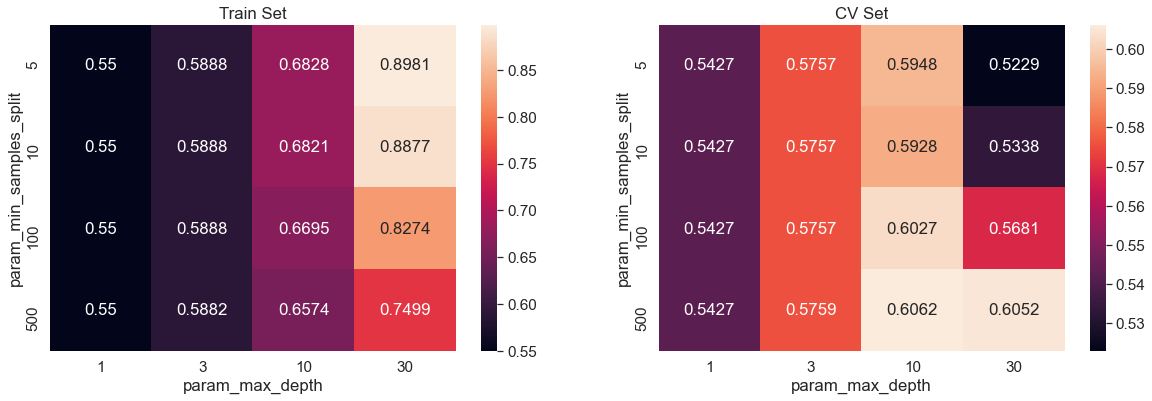

In [ ]:
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

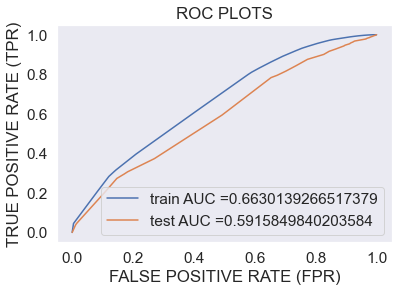

In [ ]:
dt=DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_split=500)
dt.fit(X_t, y_train);

y_train_pred = clf.predict_proba(X_t)[:,1]  
y_test_pred = clf.predict_proba(X_tt)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE (FPR)")
plt.ylabel("TRUE POSITIVE RATE (TPR)")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

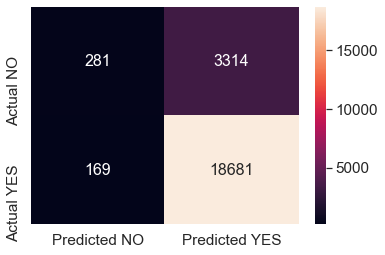

In [ ]:
#confusion matrix - train data
get_confusion_matrix(clf,X_t,y_train)

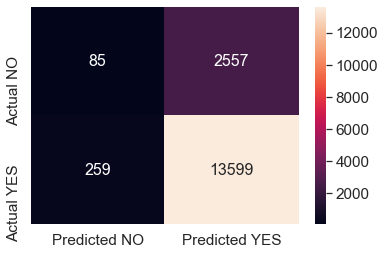

In [ ]:
#confusion matrix - test data
get_confusion_matrix(clf,X_tt,y_test)

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max Depth", "Min Samples Split", "AUC"]
x.add_row(["TFIDF", "Decision Tree", 10, 500, 0.58])
x.add_row(["TFIDF W2V", "Decision Tree", 10, 500, 0.59])
x.add_row(["non-zero Feature", "Decision Tree", 3, 500, 0.60,])

print(x)

+------------------+---------------+-----------+-------------------+------+
|    Vectorizer    |     Model     | Max Depth | Min Samples Split | AUC  |
+------------------+---------------+-----------+-------------------+------+
|      TFIDF       | Decision Tree |     10    |        500        | 0.58 |
|    TFIDF W2V     | Decision Tree |     10    |        500        | 0.59 |
| non-zero Feature | Decision Tree |     3     |        500        | 0.6  |
+------------------+---------------+-----------+-------------------+------+
